In [1]:
import pandas as pd
import numpy as np
import string
import re
from nltk.corpus import stopwords
import nltk
from nltk import word_tokenize, pos_tag
import gensim
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis.gensim
import pyLDAvis
import os
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Load and Clean data

In [2]:
twitter_df = pd.read_excel('./feminist_tweets_dataset_61.xlsx', engine='openpyxl')
# twitter_df = twitter_df[twitter_df.lang == "en"]

In [3]:
# to-do - filter tweets by date
text = twitter_df.text

In [4]:
def clean_data(text):
    clean_text = text.replace('&amp;', 'and')
    # removing handle names
    clean_text = clean_text.replace('@[^\s]+', '', regex=True)
    # remove non-ASCII characters
    st = set(string.printable)
    clean_text = clean_text.apply(lambda x: ''.join([" " if i not in st else i for i in x]))
    # removing urls
    clean_text = clean_text.replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
    # converting to no caps
    clean_text = clean_text.str.lower()
    # replace non-alphabet characters with space
    clean_text = clean_text.replace('[^a-zA-Z1-9 ]', ' ', regex=True)
    # remove stopwords
    clean_text = clean_text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))
    return clean_text

In [5]:
text = clean_data(text)

## Prepare text

In [6]:
def sent_to_words(sentences):
    stemmer = SnowballStemmer('english')
    for sentence in tqdm(sentences):
        is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
        tokenized = word_tokenize(sentence)
        all_nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos) and word != 'amp'] 
        lemmatized_tokens = [stemmer.stem(WordNetLemmatizer().lemmatize(word)) for word in all_nouns_adj]
        sentence = " ".join(lemmatized_tokens)
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [7]:
# convert sentences to list of words per sentence
words_sent_list = list(sent_to_words(text))

100%|█████████████████████████████████████████████████████████████████████████████| 9061/9061 [00:16<00:00, 536.93it/s]


In [8]:
# create bigrams - for words that commonly occur together
bigram = gensim.models.Phrases(words_sent_list, min_count=20, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

bigram_words_list_ = [bigram_mod[doc] for doc in words_sent_list]
# bigram_words_list = [list_ for list_ in bigram_words_list_ if list_ != []]

index_list = []
bigram_words_list = []
    
for i, list_ in enumerate(tqdm(bigram_words_list_)):
    if list_ != []:
        index_list.append(i)
        bigram_words_list.append(list_)

100%|█████████████████████████████████████████████████████████████████████████| 9061/9061 [00:00<00:00, 2260428.75it/s]


In [9]:
# create Dictionary
id2word = corpora.Dictionary(bigram_words_list)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in bigram_words_list]

In [10]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('african', 1),
  ('alumna', 1),
  ('american', 1),
  ('announc', 1),
  ('capitol', 1),
  ('chief', 1),
  ('david', 1),
  ('dr', 1),
  ('first', 1),
  ('pittman', 1),
  ('polic', 1),
  ('role', 1),
  ('wilson', 1),
  ('woman', 1),
  ('yogananda', 1)]]

## LDA Mallet

In [11]:
# os.environ['MALLET_HOME']='C:\\Users\\arnab\\OneDrive\\Desktop\\mallet-2.0.8\\' 
# mallet_path = 'C:\\Users\\arnab\\OneDrive\\Desktop\\mallet-2.0.8\\bin\\mallet'

# os.environ['MALLET_HOME']='C:\\mallet' 
mallet_path = 'C:\\mallet\\bin\\mallet'

In [12]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model=LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, iterations = 300, random_seed=12345)
        model_list.append(model)
        coherence_model_ldamallet = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherence_model_ldamallet.get_coherence())

    return model_list, coherence_values

In [13]:
# import pickle

# with open('model_list.pkl', 'rb') as f:
#     model_list = pickle.load(f)
    
# with open('coherence_values.pkl', 'rb') as f:
#     coherence_values = pickle.load(f)

In [14]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=bigram_words_list, limit=20, start=3, step=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [07:50<00:00, 27.65s/it]


In [15]:
# import pickle

# with open('model_list.pkl', 'wb') as f:
#     pickle.dump(model_list, f)
    
# with open('coherence_values.pkl', 'wb') as f:
#     pickle.dump(coherence_values, f)

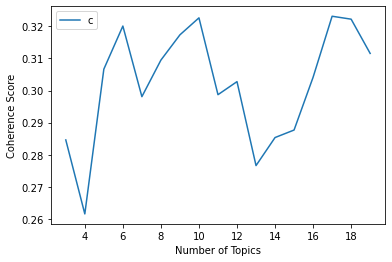

In [16]:
# # Show graph
limit=20; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc='best')

In [17]:
pyLDAvis.enable_notebook()

# LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(11))

# model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model_list[1])
mallet_model = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, iterations=300, random_seed=12345)
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model)
LDAvis_prepared = pyLDAvis.gensim.prepare(model, corpus, id2word)

LDAvis_prepared

C:\ProgramFiles\anaconda3\envs\twitter\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\ProgramFiles\anaconda3\envs\twitter\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\ProgramFiles\anaconda3\envs\twitter\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.193199 -0.327151       1        1  10.128040
3      0.165959  0.024330       2        1  10.054571
0      0.140331 -0.092414       3        1  10.037441
2     -0.027460 -0.228506       4        1  10.020521
7     -0.251852  0.164981       5        1  10.005448
9      0.115808  0.130951       6        1   9.991666
6      0.147464  0.081730       7        1   9.975664
4      0.245389  0.051797       8        1   9.959514
1     -0.267105  0.230957       9        1   9.927645
5     -0.075335 -0.036676      10        1   9.899489, topic_info=         Term         Freq        Total Category  logprob  loglift
107      educ  3327.000000  3327.000000  Default  30.0000  30.0000
13      woman  2638.000000  2638.000000  Default  29.0000  29.0000
193      girl  7004.000000  7004.000000  Default  28.0000  28.0000
91      covid  1573.000000  1573.000000  Default  27.0000  27.0000
192     young  1517.000000  1517.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
444  progress   250.360979   380.231824  Topic10  -3.7930   1.8948
37      great   148.362061   204.530943  Topic10  -4.3163   1.9916
230     power   191.634329   345.150684  Topic10  -4.0604   1.7243
193      girl   373.996030  7004.458566  Topic10  -3.3917  -0.6174
166    leader   151.452938   614.034950  Topic10  -4.2957   0.9129

[762 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
824      10  1.002111     abl
709       8  1.003093    abus
602       2  0.020701  access
602       3  0.887864  access
602       8  0.089706  access
...     ...       ...     ...
1140      1  0.043099   youth
1140      8  0.006157   youth
1140      9  0.948169   youth
2289      2  0.969005    zira
2230      8  0.939260    zone

[886 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 1, 3, 8, 10, 7, 5, 2, 6])

In [18]:
def format_topics_sentences(ldamallet, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(tqdm(ldamallet[corpus])):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamallet.show_topic(topic_num, num_words=30)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [19]:
df_topic_sents_keywords = format_topics_sentences(ldamallet=mallet_model, corpus=corpus, texts=bigram_words_list)

  0%|                                                                                         | 0/9058 [00:00<?, ?it/s]C:\ProgramFiles\anaconda3\envs\twitter\lib\site-packages\gensim\models\wrappers\ldamallet.py:442: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")
100%|█████████████████████████████████████████████████████████████████████████████| 9058/9058 [00:22<00:00, 395.01it/s]


In [20]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [21]:
out_df = pd.concat((twitter_df.iloc[index_list][['screen_name', 'text', 'created_at']].reset_index(), df_dominant_topic), axis=1)
out_df

,index,screen_name,text,created_at,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,AASCUPolicy,.@MorganStateU Alumna Yogananda D. Pittman App...,2021-01-12 17:14:20.000000,0,7.0,0.1389,"woman, year, day, work, govern, today, adolesc...","[alumna, yogananda, pittman, chief, capitol, p..."
1,1,AASCUPolicy,Analysis of Fed Experiment on Short-Term Pell\...,2020-12-16 16:05:14.000000,1,4.0,0.1667,"girl, school, student, social, onlin, action, ...","[analysi, experi, short, term, benefit, shorte..."
2,2,AASCUPolicy,"On 9.25.1981, Justice Sandra Day O'Connor was ...",2020-09-25 17:40:04.000000,2,7.0,0.1528,"woman, year, day, work, govern, today, adolesc...","[justic, day, sworn, woman, justic, suprem, co..."
3,3,AASCUPolicy,AASCU's @PresMillieG recognized the legacy of ...,2020-09-21 18:38:10.000000,3,7.0,0.1406,"woman, year, day, work, govern, today, adolesc...","[legaci, justic, ruth, bader, ginsburg, grate,..."
4,4,AASCUPolicy,We have lost a pioneer &amp; champion for wome...,2020-09-19 13:50:38.000001,4,8.0,0.1193,"educ, gender, equal, chang, learn, teacher, qu...","[pioneer, champion, woman, equal, justic, rgb,..."
...,...,...,...,...,...,...,...,...,...
9053,9056,ASERPAKISTAN,Through assessment of children’s basic compete...,2020-03-09 11:15:23.000000,9053,8.0,0.1313,"educ, gender, equal, chang, learn, teacher, qu...","[assess, child, basic, compet, regular, impact..."
9054,9057,ASERPAKISTAN,The latest Annual Status of Education Report @...,2020-03-09 11:15:18.000000,9054,4.0,0.1498,"girl, school, student, social, onlin, action, ...","[latest, annual, status, educ, report, child, ..."
9055,9058,ASERPAKISTAN,Our students from Fatima Jinnah Girls High Sch...,2020-03-09 11:15:14.000000,9055,8.0,0.1438,"educ, gender, equal, chang, learn, teacher, qu...","[student, jinnah, girl, high, school, shehzada..."
9056,9059,ASERPAKISTAN,With evidence that where you have Equality the...,2020-03-09 04:27:27.000000,9056,5.0,0.1132,"world, endchildmarriag, life, girlsfirstfund, ...","[evid, equal, girl]"


In [22]:
out_df.to_csv('output.csv', index=False)